# Poisson Equation
We consider the two dimensional Poisson equation for two PINNs as in https://arxiv.org/pdf/2109.09444.pdf.
$$
\begin{cases}
    u_{xx} + u_{yy} = f \text{ for } (x,y)\in [0,1]\times [0,1] \\
    u(0, y) = u(1, y) = u(x, 0) = u(x, 1)= 0 \\
\end{cases}
$$

In this case, we consider:
$$
\begin{cases}
    f = 1 \text{ for }(x,y)\in [0.25,0.75] \times [0.25,0.75]\\
    f = 0 \text{    else}
\end{cases}
$$

In [11]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp

from jax import config

config.update("jax_enable_x64", True)

## Initializing the PINN

In [12]:
from utils import data_path

file = data_path / "poisson_overlap_train.json"
file_test = data_path / "poisson_overlap_test.json"
activation = np.tanh
xpinn = XPINN(file, activation)

We visualize the points of the domain decomposition.

(744, 2)
(120, 2)
(321, 2)
(165, 2)


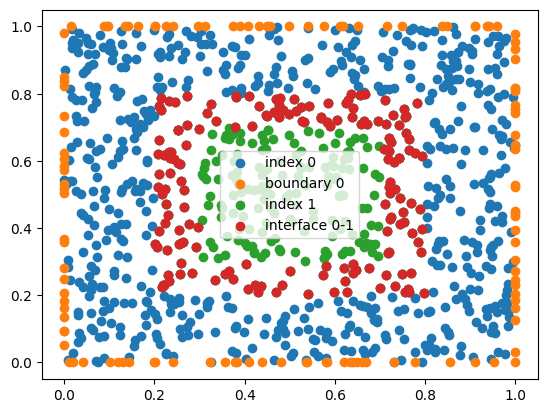

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    print(pinn.interior.shape)
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if pinn.boundary.size != 0:
        print(pinn.boundary.shape)
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    print(p.shape)
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

### PINN Formalization
We only consider boundary loss for the outer PINN.

### Setting the loss function
We create a base function for initializing the boundary loss functions, which is relatively simple in this case. 

In [14]:
from typing import Callable
from type_util import Params
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))


def boundary_loss_factory(target: float | Array) -> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss

In [15]:
def interior_loss_factory(index: int, rhs: float) -> LFunc:

    def hess(params):
        return hessian(lambda x: model(params, x))

    def residual(params, x):
        return np.trace(hess(params)(x)[0]) - rhs

    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts) ** 2)

    return interior_loss

Setting the boundary and interior loss

In [16]:
p0, p1 = xpinn.PINNs

p0.boundary_loss = boundary_loss_factory(0.0)

p0.interior_loss = interior_loss_factory(0, 0.0)  # implementing rhs
p1.interior_loss = interior_loss_factory(1, 1.0)

Setting the interface loss

In [17]:
def interface_loss_factory(i: int, j: int) -> LFunc:
    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return 80 * (res_ij + avg_ij)

    return interface_loss

In [18]:
p0.interface_loss = interface_loss_factory(0, 1)
p1.interface_loss = interface_loss_factory(1, 0)

In [19]:
shapes = [[2] + [20] * 9 + [1]] * 2
optimizer = optax.adam(learning_rate=0.0001)
xpinn.initialize_params(shapes, optimizer)

In [20]:
n_iter = 10000
losses = xpinn.run_iters(n_iter)

Text(0.5, 1.0, 'Loss per Pinn over 20000 epochs')

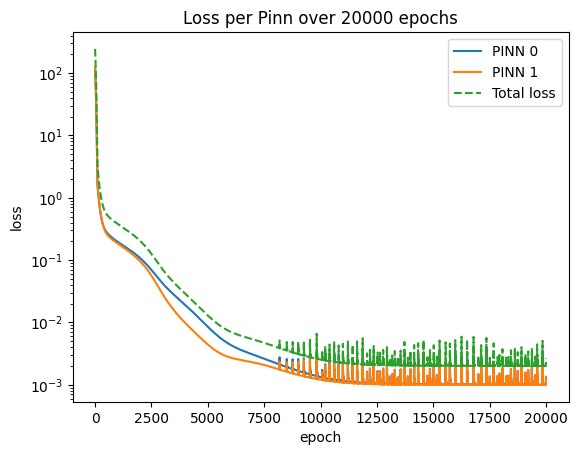

In [ ]:
a_losses = losses
t_0 = 0
t_end = min(20000, n_iter)
t = np.arange(t_0, t_end)

for i in range(2):
    plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

In [ ]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()
# min_, max_ = 0, 1

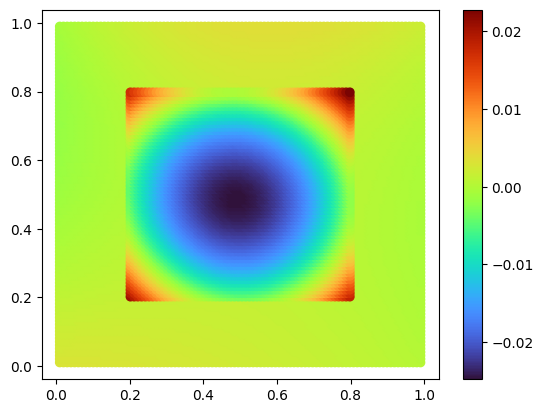

In [ ]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()

In [ ]:
p1 = xpinn.PINNs[1]
p1.loss(p1.params, xpinn.main_args[1])

Array(0.00104544, dtype=float64)

In [ ]:
p0 = xpinn.PINNs[0]
p0.loss(p0.params, xpinn.main_args[0])

Array(0.00104818, dtype=float64)

In [ ]:
p0.interface_loss(p0.params, xpinn.main_args[0])

Array(0.00103548, dtype=float64)

In [ ]:
p0.boundary_loss(p0.params, xpinn.main_args[0])

Array(4.09324616e-06, dtype=float64)

In [ ]:
p0.interior_loss(p0.params, xpinn.main_args[0])

Array(8.60973302e-06, dtype=float64)

In [ ]:
p0.v_residual(p0.params, xpinn.main_args[0]["interior"])

Array([-1.32783795e-03, -4.05843552e-03,  2.92450299e-03,  2.51446847e-03,
        8.65674686e-05, -2.07640729e-03,  1.66400431e-03,  1.37504985e-03,
       -4.09959051e-03,  9.73707895e-04,  2.13051973e-03,  3.15424331e-03,
       -2.78066052e-03, -3.64048454e-03, -6.22295246e-03, -1.83277620e-03,
       -2.04701457e-03,  2.86711591e-03,  1.11238242e-03, -1.62367414e-03,
        1.25724905e-03,  2.22562349e-03,  4.84637294e-03, -4.16894767e-03,
        3.42453667e-03,  3.40604612e-03,  5.51543491e-05,  6.33184994e-04,
        2.79933427e-03,  7.51392873e-04, -1.20683502e-03, -2.66428416e-03,
        2.36002733e-03,  4.83836710e-06,  2.13839895e-03,  6.32729289e-04,
        1.13657910e-03,  1.15773659e-03, -2.76677254e-03,  3.45756440e-03,
        1.75458060e-03,  2.00468803e-03,  4.20884500e-03, -1.91754511e-03,
       -4.71012672e-04,  1.72738868e-03, -2.18329631e-03,  2.44059094e-03,
        3.10266497e-03,  3.56103572e-04, -5.40706839e-03, -1.23610167e-03,
        5.14755251e-03, -

In [ ]:
p1.v_residual(p1.params, xpinn.main_args[1]["interior"]).shape

(321,)

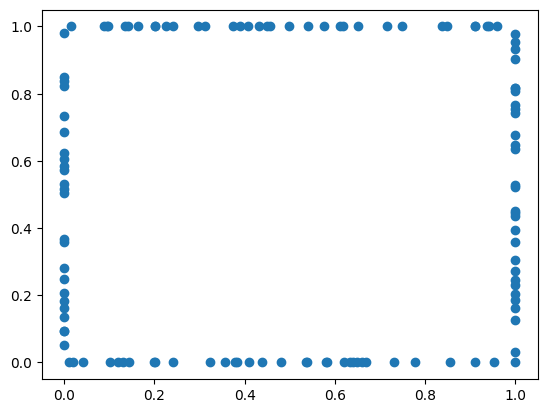

In [ ]:
plt.plot(
    xpinn.main_args[0]["boundary"][:,
                                   0], xpinn.main_args[0]["boundary"][:, 1], "o"
)

In [ ]:
rhs = 0.0


def hess(params):
    return hessian(lambda x: model(params, x))


def residual(params, x):
    return np.trace(hess(params)(x)[0]) - rhs

In [ ]:
x = xpinn.main_args[0]["interior"][0]
np.trace(hess(p0.params)(x))

Array([-0.00745775,  0.01363061], dtype=float64)

In [ ]:
hess(p0.params)(x)[0]

Array([[-0.00745775,  0.01363061],
       [ 0.01363061,  0.00612991]], dtype=float64)